In [1]:
import kmodels as kmk
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask.array as da
from torch.nn import functional as F
import pickle

c:\Users\efons\anaconda3\envs\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def split_df_into_subjects(df):
    subject_names = df['Subject'].unique()
    return [df[df['Subject'] == subject] for subject in subject_names]

def split_subject_df(subject_df):
    # get the time column for the subject
    time = subject_df['Time'].values
    # get the indices where the time resets to its minimum value
    time_splits = np.where(time == time.min())[0]
    # split the subject index into events
    subject_events = np.split(subject_df.index, time_splits)
    # get rid of the empty lists in the list of lists
    subject_events = [i for i in subject_events if len(i) > 0]
    # return the list of events
    return [subject_df.loc[event] for event in subject_events]

def sliding_event_df(event_df, window_size, stride):
    # get the number of rows in the event
    num_rows = event_df.shape[0]
    # get the number of windows in the event
    num_windows = (num_rows - window_size) // stride + 1
    # get the indices of the windows
    window_indices = [np.arange(i, i + window_size) for i in range(0, num_windows * stride, stride)]
    # return the list of windows
    return [event_df.iloc[window] for window in window_indices]

class Dataset_LSTM(torch.utils.data.Dataset):
    def __init__(self, df, window_size = 50, stride = 10, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], sort_column=['Event','Subject']):
        self.df = df
        self.xcols = xcols
        self.ycols = ycols
        self.window_size = window_size
        self.stride = stride
        
        # get the subjects from the dataframe
        subjects = split_df_into_subjects(df)
        subject_events = [split_subject_df(subject) for subject in subjects]
        # for each event create a sliding window using the window size and stride
        subject_event_windows = [[sliding_event_df(event, window_size, stride) for event in subject] for subject in subject_events]
        # flatten the list of lists
        subject_event_windows = [window for subject in subject_event_windows for event in subject for window in event]
        self.x_windows = [window[xcols].values for window in subject_event_windows]
        self.y_windows = [window[ycols].values for window in subject_event_windows]
        # save X for an LSTM model. the X shape should be (num_windows, window_size, num_features)
        self.X = np.array([np.expand_dims(x, axis=0) for x in self.x_windows])
        self.X = self.X.reshape(self.X.shape[0], self.X.shape[2], self.X.shape[3])
        # save Y for an LSTM model. the Y shape should be (num_windows, window_size, num_features)
        self.Y = np.array([np.expand_dims(y, axis=0) for y in self.y_windows])
        self.Y = self.Y.reshape(self.Y.shape[0], self.Y.shape[2], self.Y.shape[3])
        # save the number of windows
        self.num_windows = self.X.shape[0]
        # save the number of features
        self.num_features = self.X.shape[2]
        # save the number of outputs
        self.num_outputs = self.Y.shape[2]
        # save all the variables we used to the class
        self.subjects = subjects
        self.subject_events = subject_events
        self.subject_event_windows = subject_event_windows
        self.sort_column = sort_column
    
    def __len__(self):
        return self.num_windows
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
        
def split_df_into_subjects_dask(df):
    subject_names = df['Subject'].unique().compute()
    return [df[df['Subject'] == subject] for subject in subject_names]

def split_subject_df_dask(subject_df):
    # get the time column for the subject
    time = subject_df['Time'].values.compute()
    # get the indices where the time resets to its minimum value
    time_splits = np.where(time == time.min())[0]
    # split the subject index into events
    subject_events = da.split(subject_df.index.compute(), time_splits)
    # get rid of the empty lists in the list of lists
    subject_events = [i for i in subject_events if len(i) > 0]
    # return the list of events
    return [subject_df.loc[event] for event in subject_events]

def sliding_event_df_dask(event_df, window_size, stride):
    # get the number of rows in the event
    num_rows = event_df.shape[0].compute()
    # get the number of windows in the event
    num_windows = (num_rows - window_size) // stride + 1
    # get the indices of the windows
    window_indices = [da.arange(i, i + window_size) for i in range(0, num_windows * stride, stride)]
    # return the list of windows
    return [event_df.iloc[window] for window in window_indices]


# lets write a function that will plot the prediction of the model on a event dataframe from the dataclass 
def get_event_prediction(event_df, model, window_size = 100, stride=5, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], device='cuda'):
    # get the number of rows in the event
    num_rows = event_df.shape[0]
    window_dfs = sliding_event_df(event_df, window_size = num_rows, stride = 1)
    # get the X and Y values for the event
    X = np.array([window[xcols].values for window in window_dfs])
    Y = np.array([window[ycols].values for window in window_dfs])
    # reshape the X and Y values for the model
    X = np.expand_dims(X, axis=0)
    X = X.reshape(X.shape[0], X.shape[2], X.shape[3])
    Y = np.expand_dims(Y, axis=0)
    Y = Y.reshape(Y.shape[0], Y.shape[2], Y.shape[3])
    # get the prediction from the model
    Y_pred = model(torch.tensor(X, dtype=torch.float32).to(device))
    # get the prediction and actual values from the tensors
    Y_pred = Y_pred.detach().cpu().numpy()
    # knowing the stride we know that the prediction is every stride number of rows
    # lets make a list of indexs to keep track of which windows belond to which time points
    window_indices = [i.index for i in window_dfs]
    # go into each window indicies and append the predicitnos to each dataframe Fx_pred, Fy_pred, Fz_pred
    window_dfs = [window_dfs[i].assign(Fx_pred = Y_pred[0][i][0], Fy_pred = Y_pred[0][i][1], Fz_pred = Y_pred[0][i][2]) for i in range(len(window_dfs))]
    window_merged = pd.concat(window_dfs)
    # take the mean of each index using the window indices
    event_df = window_merged.groupby(window_merged.index).mean()
    return window_dfs

In [3]:
class Dataset_LSTM_Parallel(torch.utils.data.Dataset):
    def __init__(self, df, window_size = 50, stride = 10, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], sort_column=['Event','Subject']):
        self.df = dd.from_pandas(df, npartitions=4)
        self.xcols = xcols
        self.ycols = ycols
        self.window_size = window_size
        self.stride = stride
        self.sort_column = sort_column
        
        self.df = self.df.map_partitions(split_df_into_subjects, meta=(None,))
        self.df = self.df.map_partitions(split_subject_df, meta=(None,))
        self.df = self.df.map_partitions(lambda x: [sliding_event_df(event, window_size, stride) for event in x], meta=(None,))
        self.df = self.df.flatten()
        self.df = self.df.map(lambda x: x[xcols + ycols], meta=(None,))
        self.df = self.df.repartition(npartitions=4)
        
        self.X = da.stack([self.df[xcols].to_dask_array() for _, self.df in self.df.groupby(sort_column)], axis=0)
        self.X = self.X.reshape(-1, window_size, len(xcols))
        self.Y = da.stack([self.df[ycols].to_dask_array() for _, self.df in self.df.groupby(sort_column)], axis=0)
        self.Y = self.Y.reshape(-1, window_size, len(ycols))
        
        self.num_windows = self.X.shape[0]
        self.num_features = self.X.shape[2]
        self.num_outputs = self.Y.shape[2]
        
    def __len__(self):
        return self.num_windows
    
    def __getitem__(self, idx):
        return self.X[idx].compute(), self.Y[idx].compute()
    
class lstm(nn.Module):
    def __init__(self, n_inputs=8, hidden_size=30, n_outputs=300, n_linear_layers=1, 
                 layer_size=10, lstm_n_outputs=30):
        super().__init__()
        self.lstm = nn.LSTM(n_inputs, hidden_size, batch_first=True)
        self.fcs = nn.ModuleList([nn.Linear(layer_size, layer_size) for i in range(n_linear_layers)])
        self.layer_size = layer_size
        self.n_linear_layers = n_linear_layers 
        self.lstm_n_outputs = lstm_n_outputs
        self.output = nn.Linear(layer_size, n_outputs)
        
    def forward(self, x):
        rows = x.shape[0]
        x, _ = self.lstm(x)
        x = x.reshape(rows, -1)
        for i, fc in enumerate(self.fcs):
            if fc == self.fcs[0]:
                if x.shape[1] != int(fc.in_features):
                    try:    
                        self.fcs[0] = nn.Linear(x.shape[1], self.layer_size)
                        x = F.relu(self.fcs[0](x))
                    except:
                        self.fcs[0] = nn.Linear(x.shape[1], self.layer_size).to('cuda')
                        x = F.relu(self.fcs[0](x))
                else:
                    x = F.relu(fc(x))
            else:
                x = F.relu(fc(x))
        x = self.output(x)
        return x


In [4]:
df = pd.read_pickle('../data/LP_Simulations_Formatted.pkl')
df

,Time,FCU,EPL,EPB,FPL,APL,FPB,OPP,Fx,Fy,Fz,ADD,Subject
0,0.000000,0.054566,0.058537,0.062743,0.155728,0.023906,0.021142,0.070465,-9.259692,-4.447818,-6.536988,0.026819,6.26_0.9_1.06
1,0.009799,0.054646,0.058400,0.062911,0.154414,0.023787,0.021018,0.077124,-9.502468,-4.600985,-6.520491,0.026349,6.26_0.9_1.06
2,0.019599,0.054800,0.057753,0.062681,0.153220,0.023763,0.021220,0.095268,-9.513043,-4.624847,-6.518658,0.026434,6.26_0.9_1.06
3,0.029398,0.056122,0.056917,0.063201,0.157919,0.023762,0.022113,0.114959,-9.409544,-4.564386,-6.497891,0.026648,6.26_0.9_1.06
4,0.039197,0.057602,0.056416,0.063981,0.163014,0.023785,0.023148,0.126942,-9.251525,-4.474644,-6.437751,0.026858,6.26_0.9_1.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345171,1.950067,0.077327,0.028705,0.070763,0.186818,0.081797,0.022118,0.090759,-4.916051,-5.716611,-12.003086,0.024750,6.53_1.04_1.02
1345172,1.959866,0.077751,0.027808,0.071065,0.191791,0.082448,0.022103,0.095652,-5.248973,-5.937422,-12.067884,0.024120,6.53_1.04_1.02
1345173,1.969666,0.078584,0.027024,0.071566,0.193814,0.083229,0.022089,0.093776,-5.556444,-6.157407,-12.143441,0.023570,6.53_1.04_1.02
1345174,1.979465,0.078977,0.026315,0.071994,0.195077,0.083762,0.022077,0.086941,-5.809779,-6.380327,-12.206728,0.023072,6.53_1.04_1.02


In [5]:
# first lets split the dataframe into a train and test set using the Subject column. Keep subjects separate during training and testing
#df = dd.from_pandas(df, npartitions=4)
subject_dfs = split_df_into_subjects(df)
train_split = 0.8
n_train_subjects = int(len(subject_dfs) * train_split)
n_test_subjects = len(subject_dfs) - n_train_subjects


In [6]:
n_test_subjects, n_train_subjects

(104, 414)

In [7]:
# randomly pick the subjects to use for training and testing
train_subjects_index = np.random.choice(len(subject_dfs), n_train_subjects, replace=False)
train_df = pd.concat([subject_dfs[i] for i in train_subjects_index])
test_df = pd.concat([subject_dfs[i] for i in range(len(subject_dfs)) if i not in train_subjects_index])

In [8]:
train_data = Dataset_LSTM(train_df, sort_column=['Subject'], window_size=100, stride=5)

In [9]:
test_data = Dataset_LSTM(test_df, sort_column=['Subject'], window_size=100, stride=5)

In [10]:
train_data.X.shape, test_data.X.shape
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
train_data.X = scale.fit_transform(train_data.X.reshape(-1, train_data.num_features)).reshape(train_data.X.shape)
test_data.X = scale.transform(test_data.X.reshape(-1, test_data.num_features)).reshape(test_data.X.shape)


In [11]:
train_data.X = torch.from_numpy(train_data.X).float()
train_data.Y = torch.from_numpy(train_data.Y).float()
test_data.X = torch.from_numpy(test_data.X).float()
test_data.Y = torch.from_numpy(test_data.Y).float()

In [12]:
train_data[0]

(tensor([[-4.1881e-02,  3.7371e-01, -3.8972e-01, -2.2495e-01, -2.3817e-01,
           1.7572e-01, -4.6382e-01, -8.8015e-01],
         [-2.9460e-02,  4.0364e-01, -3.8093e-01, -2.3746e-01, -2.4684e-01,
           2.1763e-01, -4.6810e-01, -1.0764e+00],
         [-1.7265e-02,  4.2749e-01, -3.6403e-01, -2.4894e-01, -2.5456e-01,
           2.4920e-01, -4.7183e-01, -1.2639e+00],
         [-1.8640e-03,  4.3566e-01, -3.3747e-01, -2.5876e-01, -2.6109e-01,
           2.8703e-01, -4.7505e-01, -1.4255e+00],
         [ 1.2811e-02,  4.4900e-01, -3.2603e-01, -2.6675e-01, -2.6643e-01,
           3.1840e-01, -4.7777e-01, -1.5535e+00],
         [ 2.4002e-02,  4.5808e-01, -3.1923e-01, -2.7215e-01, -2.7007e-01,
           3.3110e-01, -4.7967e-01, -1.5210e+00],
         [ 3.4266e-02,  4.4710e-01, -3.2064e-01, -2.7624e-01, -2.7285e-01,
           3.2958e-01, -4.8113e-01, -1.2992e+00],
         [ 7.8244e-02,  3.9728e-01, -2.6952e-01, -2.8070e-01, -2.7589e-01,
           3.7132e-01, -4.8273e-01, -1.0602e+00],


Text(0, 0.5, 'Force')

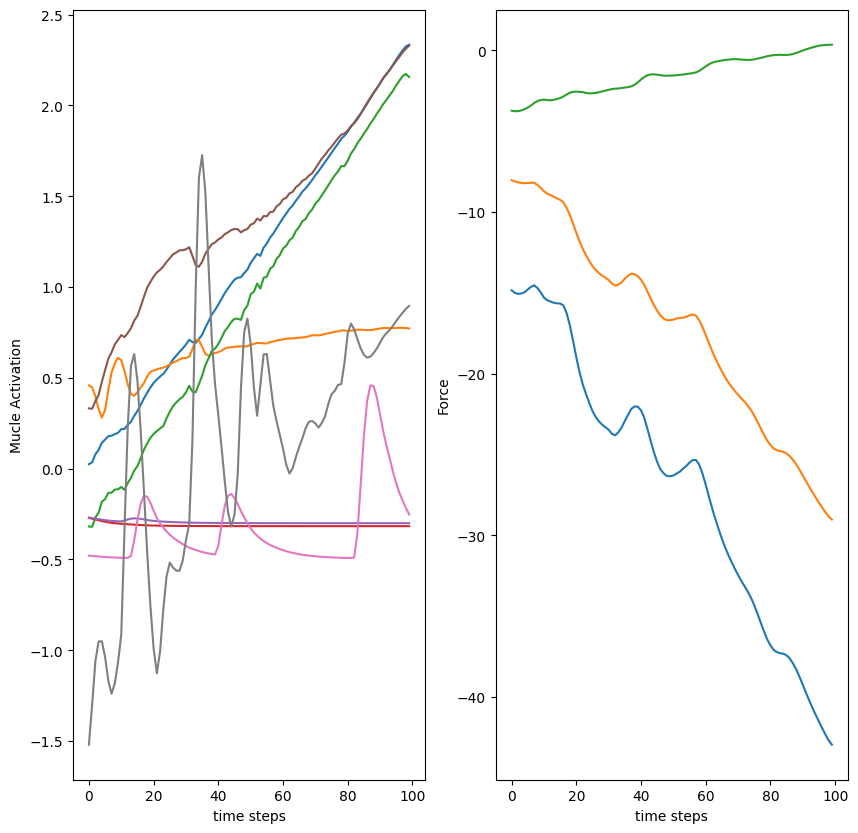

In [13]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].plot(train_data[1][0])
ax[0].set_xlabel('time steps')
ax[0].set_ylabel('Mucle Activation')
ax[1].plot(train_data[1][1])
ax[1].set_xlabel('time steps')
ax[1].set_ylabel('Force')

In [14]:
model = lstm(n_linear_layers=3, n_outputs = len(train_data.Y[0].flatten()), lstm_n_outputs = 3000, layer_size=30).to('cuda')
model

lstm(
  (lstm): LSTM(8, 30, batch_first=True)
  (fcs): ModuleList(
    (0): Linear(in_features=30, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
  )
  (output): Linear(in_features=30, out_features=300, bias=True)
)

In [15]:
# PASS A SAMPLE THROUGH TO FIX THE MODEL DIMENSIONS
model(train_data.X[0:10].to('cuda'))
model

lstm(
  (lstm): LSTM(8, 30, batch_first=True)
  (fcs): ModuleList(
    (0): Linear(in_features=3000, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
  )
  (output): Linear(in_features=30, out_features=300, bias=True)
)

In [16]:
losses = kmk.run_Pytorch(model, train_data.X.reshape(-1, 100, 8), train_data.Y, n_epochs=101, batch_size=256*16, learning_rate=1e-3, device='cuda')

EPOCH :  0 , dt:  2.062492609024048 seconds, losses : 155.8296661376953
EPOCH :  10 , dt:  18.106311798095703 seconds, losses : 4.855318546295166
EPOCH :  20 , dt:  18.442132234573364 seconds, losses : 2.1752588748931885
EPOCH :  30 , dt:  18.162980318069458 seconds, losses : 1.8686120510101318
EPOCH :  40 , dt:  18.608503818511963 seconds, losses : 1.7519726753234863
EPOCH :  50 , dt:  19.10819363594055 seconds, losses : 1.6225134134292603
EPOCH :  60 , dt:  18.567410469055176 seconds, losses : 1.5620800256729126
EPOCH :  70 , dt:  19.05459189414978 seconds, losses : 1.5765506029129028
EPOCH :  80 , dt:  19.699273586273193 seconds, losses : 1.4985718727111816
EPOCH :  90 , dt:  22.972913026809692 seconds, losses : 1.5331065654754639
EPOCH :  100 , dt:  30.60021162033081 seconds, losses : 1.4104945659637451


In [19]:
import gc
def batch_predict(model, input, batch_size=500):
    n_batches = int(np.ceil(input.shape[0] / batch_size))
    for i in range(n_batches):
        gc.collect()
        torch.cuda.empty_cache()
        if i == 0:
            output = model(input[i*batch_size:(i+1)*batch_size]).detach().cpu()
        else:
            output = torch.cat((output, model(input[i*batch_size:(i+1)*batch_size]).detach().cpu())).detach().cpu()
    return output

In [20]:
torch.cuda.empty_cache()
gc.collect()
batch_predict(model, train_data.X.to('cuda'))

KeyboardInterrupt: 

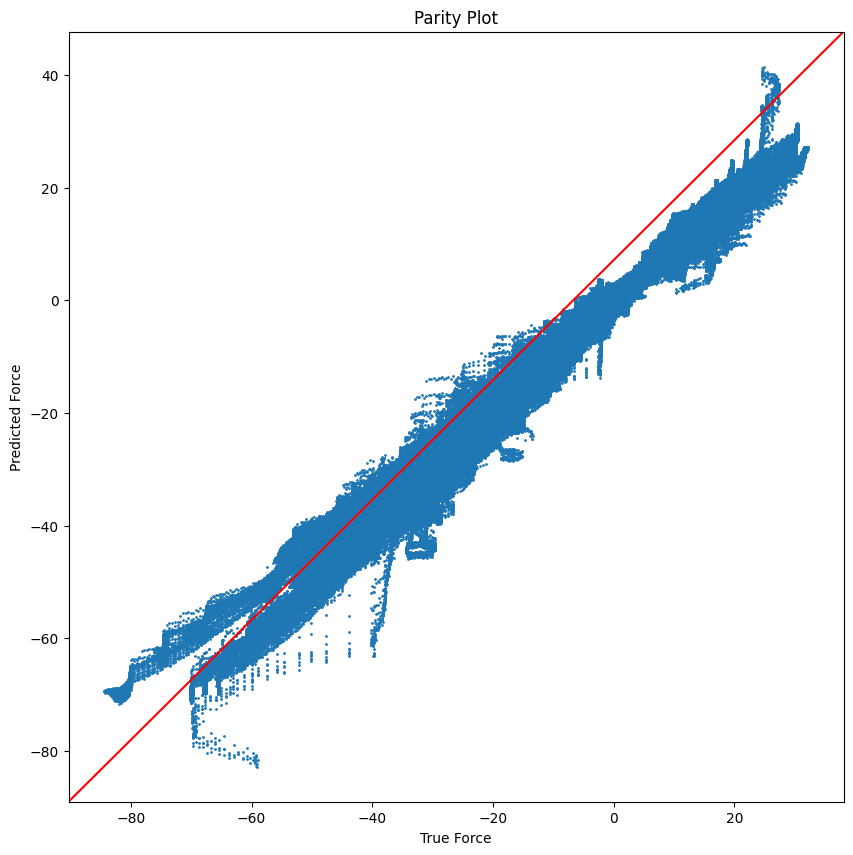

In [21]:
pred = batch_predict(model, test_data.X.to('cuda'), batch_size=256*16)
# lets make a beautiful parity plot worthy of a Nobel Prize
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(test_data.Y.flatten(), pred.flatten(), s=1)
ax.set_xlabel('True Force')
ax.set_ylabel('Predicted Force')
ax.set_title('Parity Plot') 
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='red')

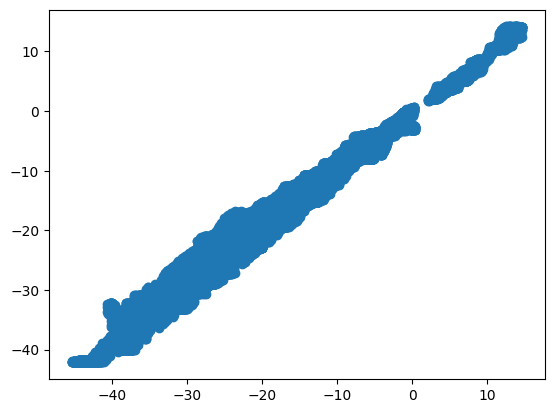

In [186]:

pred = model(train_data.X[0:n].to('cuda')).detach().cpu().numpy().reshape(-1,1)
y = train_data.Y[0:n].detach().cpu().numpy().reshape(-1,1)
plt.scatter(pred, y, edgecolors='k', alpha=0.5)
# make sure the aspect ratio is 1:1

In [23]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
r2 = r2_score(y, pred)
mae = mean_absolute_error(y, pred)
mse = mean_squared_error(y, pred)
print('r2: ', r2, 'mae: ', mae, 'mse: ', mse)


r2:  0.9719301311945697 mae:  1.1206858 mse:  2.441049


r2:  0.9818686577627971 mae:  0.8303109 mse:  1.5054909


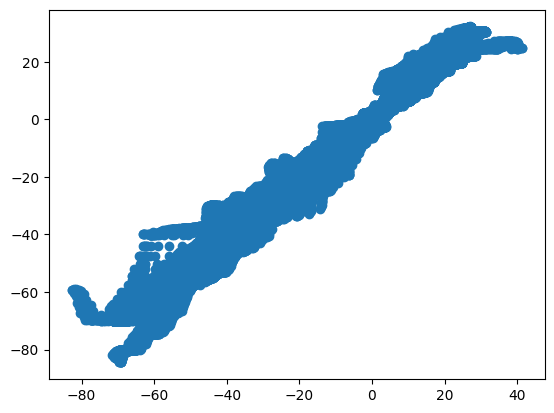

In [29]:
model = model.to('cuda')
pred = batch_predict(model, test_data.X.to('cuda'), batch_size=256*16).reshape(-1,1)
y_test = test_data.Y.float().detach().cpu().numpy().reshape(-1,1)
plt.scatter(pred, y_test)
r2 = r2_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
print('r2: ', r2, 'mae: ', mae, 'mse: ', mse)


(100, 3)
[-23.611143 -16.881819  12.023625]


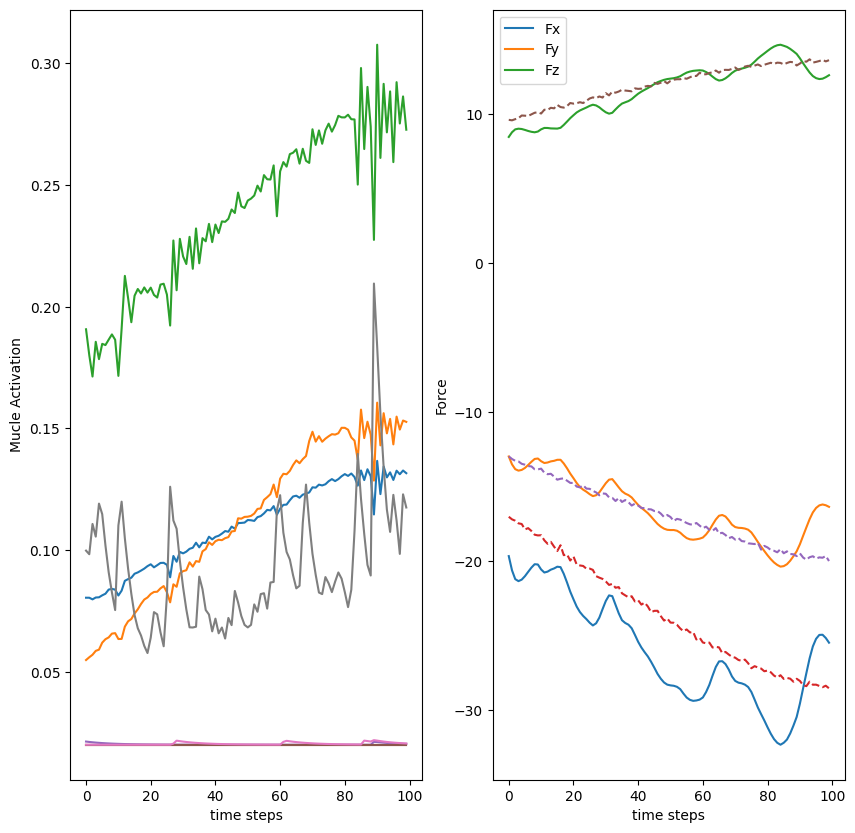

In [25]:
# plot a sample of the data
n = np.random.randint(0, len(test_data.X))
x_plot = test_data.X[n].float().detach().cpu().numpy()
y_plot = test_data.Y[n].float().detach().cpu().numpy().reshape(-1, 3)
print(y_plot.shape)
y_labels = test_data.ycols
x_labels = test_data.xcols
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].plot(x_plot)
ax[0].set_xlabel('time steps')
ax[0].set_ylabel('Mucle Activation')
ax[1].plot(y_plot)
    
ax[1].set_xlabel('time steps')
ax[1].set_ylabel('Force')
ax[1].legend(y_labels)
#plot the prediction of this sample
pred = model(test_data.X[n].float().to('cuda').unsqueeze(0)).detach().cpu().numpy().reshape(-1, 3)
ax[1].plot(pred, '--')
# print the mean prediction on the plot
pred_mean = np.mean(pred, axis=0)
print(pred_mean)

In [26]:
# save the model state dict to the model folder
import os
# import the datetime properly
from datetime import datetime
def save_model(model, name):
    # check if models folder exists
    if not os.path.exists('models'):
        os.mkdir('models')
    # check if the model already exists and add a number to the end
    if os.path.exists('models/' + name + '.pt'):
        i = 0
        while os.path.exists('models/' + name + str(i) + '.pt'):
            i += 1
        torch.save(model.state_dict(), 'models/' + name + str(i) + '.pt')
    torch.save(model.state_dict(), 'models/' + name + '.pt')
# save the model include the todays date
save_model(model, 'lstm_3layer_30nodes_200epochs_' + str(datetime.now().date())+'_2')

In [87]:
# lets write a function that will plot the prediction of the model on a event dataframe from the dataclass 
def get_event_prediction(event_df, model, window_size = 100, stride=5, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], device='cuda'):
    # get the number of rows in the event
    num_rows = event_df.shape[0]
    window_dfs = sliding_event_df(event_df, window_size = num_rows, stride = stride)
    return window_dfs

In [171]:
# test plotting a event prediciton 
ycols = test_data.ycols
print(ycols)
xcols = test_data.xcols
subject_event_df = train_data.subject_events[0][0]
pred_plot = sliding_event_df(subject_event_df, window_size = 100, stride = 5)
# get the prediciton for each window
preds = [model(torch.from_numpy(i[xcols].values).float().to('cuda')).detach().cpu().numpy() for i in pred_plot]
print(preds[0].shape)
for i, temp in enumerate(pred_plot):
    print(temp)
    temp['Fx_pred'] = preds[i][:,0]
    temp['Fy_pred'] = preds[i][:,1]
    temp['Fz_pred'] = preds[i][:,2]
plot_df = pd.concat([i for i in pred_plot])
# average all time points
group_df = plot_df.groupby(['Time']).mean()
# make time a column and remove the index
group_df['Time'] = group_df.index
group_df = group_df.reset_index(drop=True)


# lets turn all this into a function

def get_event_prediction(event_df, model, window_size = 100, stride=5, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], device='cuda'):
    # get the number of rows in the event
    num_rows = event_df.shape[0]
    window_dfs = sliding_event_df(event_df, window_size = num_rows, stride = stride)
    # get the prediciton for each window
    preds = [model(torch.from_numpy(i[xcols].values).float().to('cuda')).detach().cpu().numpy() for i in window_dfs]
    # add the prediciton to the dataframe
    for i, temp in enumerate(window_dfs):
        temp[ycols[0]+'_pred'] = preds[i][:,0]
        temp[ycols[1]+'_pred'] = preds[i][:,1]
        temp[ycols[2]+'_pred'] = preds[i][:,2]
    # average all time points
    group_df = pd.concat([i for i in window_dfs]).groupby(['Time']).mean()
    # make time a column and remove the index
    group_df['Time'] = group_df.index
    group_df = group_df.reset_index(drop=True)
    return group_df

def plot_event_prediction(event_df, model, window_size = 100, stride=5, xcols = ['EPB', 'EPL', 'FPL', 'APL', 'ADD', 'FCU', 'FPB', 'OPP'], ycols = ['Fx','Fy','Fz'], device='cuda'):
    # get the number of rows in the event
    group_df = get_event_prediction(event_df, model, window_size = window_size, stride=stride, xcols = xcols, ycols = ycols, device=device)
    # plot the data
    fig, ax = plt.subplots(1,2, figsize=(10,10))
    ax[0].plot(group_df[xcols])
    ax[0].set_xlabel('time steps')
    ax[0].set_ylabel('Mucle Activation')
    ax[1].plot(group_df[ycols])
    ax[1].set_xlabel('time steps')
    ax[1].set_ylabel('Force')
    ax[1].legend(ycols)
    #plot the prediction of this sample
    for i in ycols:
        ax[1].plot(group_df[i+'_pred'], '--')
    return group_df

['Fx', 'Fy', 'Fz']
(100, 300)
             Time       FCU       EPL       EPB       FPL       APL       FPB  \
1179324  0.000000  0.061602  0.052731  0.060375  0.161248  0.023512  0.020766   
1179325  0.009799  0.063612  0.054670  0.063159  0.167762  0.023313  0.020658   
1179326  0.019599  0.064027  0.056220  0.064775  0.167537  0.023133  0.020571   
1179327  0.029398  0.064028  0.055771  0.066016  0.168985  0.022981  0.020501   
1179328  0.039197  0.066221  0.054213  0.068187  0.178285  0.022878  0.020453   
...           ...       ...       ...       ...       ...       ...       ...   
1179419  0.930936  0.133507  0.071638  0.241487  0.590124  0.020005  0.020000   
1179420  0.940736  0.133375  0.071466  0.242664  0.590223  0.020004  0.020000   
1179421  0.950535  0.133423  0.071179  0.243851  0.591137  0.020004  0.020000   
1179422  0.960334  0.133784  0.070869  0.245981  0.599861  0.020003  0.020007   
1179423  0.970134  0.134467  0.070743  0.248633  0.607781  0.020003  0.021292  

C:\Users\efons\AppData\Local\Temp\ipykernel_9580\3021990429.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Fx_pred'] = preds[i][:,0]
C:\Users\efons\AppData\Local\Temp\ipykernel_9580\3021990429.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Fy_pred'] = preds[i][:,1]
C:\Users\efons\AppData\Local\Temp\ipykernel_9580\3021990429.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

414


C:\Users\efons\AppData\Local\Temp\ipykernel_9580\3021990429.py:37: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  group_df = pd.concat([i for i in window_dfs]).groupby(['Time']).mean()


,FCU,EPL,EPB,FPL,APL,FPB,OPP,Fx,Fy,Fz,ADD,Fx_pred,Fy_pred,Fz_pred,Time
0,0.061602,0.052731,0.060375,0.161248,0.023512,0.020766,0.088390,-8.132821,-4.297332,-5.675877,0.022813,-0.215574,-0.174865,-0.545833,0.000000
1,0.063612,0.054670,0.063159,0.167762,0.023313,0.020658,0.078645,-8.492021,-4.593229,-5.590849,0.022415,-0.209981,-0.178684,-0.557717,0.009799
2,0.064027,0.056220,0.064775,0.167537,0.023133,0.020571,0.069935,-8.662983,-4.743799,-5.531837,0.022308,-0.206157,-0.181240,-0.564925,0.019599
3,0.064028,0.055771,0.066016,0.168985,0.022981,0.020501,0.062949,-8.718547,-4.817474,-5.467713,0.022554,-0.205196,-0.181422,-0.563130,0.029398
4,0.066221,0.054213,0.068187,0.178285,0.022878,0.020453,0.065795,-8.724256,-4.878938,-5.409615,0.023513,-0.207436,-0.179649,-0.558018,0.039197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,0.146043,0.059684,0.265828,0.610424,0.020000,0.022468,0.099110,-31.629479,-26.040024,-2.825557,0.020000,-0.281139,-0.112421,-0.574718,1.950067
200,0.145758,0.059673,0.265522,0.607784,0.020000,0.022443,0.096097,-31.419790,-25.858636,-2.812216,0.020000,-0.281675,-0.112389,-0.574137,1.959866
201,0.145840,0.059583,0.265462,0.607439,0.020000,0.022293,0.095923,-31.203107,-25.687564,-2.801152,0.020000,-0.282068,-0.112368,-0.573691,1.969666
202,0.145854,0.059458,0.265366,0.606350,0.020000,0.022075,0.098364,-30.978386,-25.531285,-2.800866,0.020000,-0.282292,-0.112360,-0.573404,1.979465


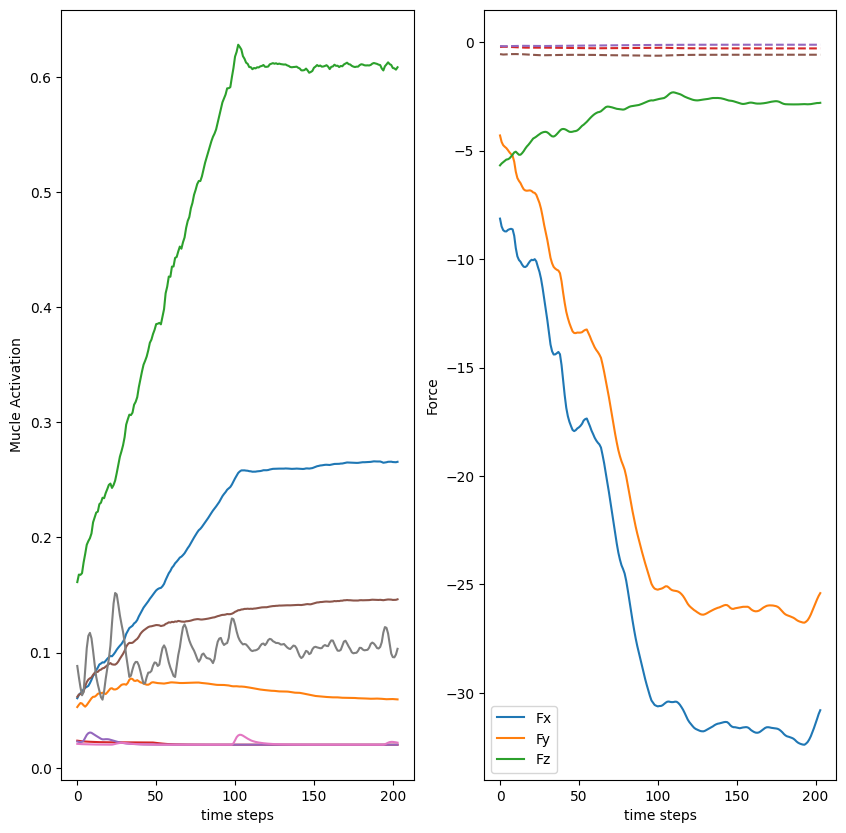

In [174]:
n = np.random.randint(0, len(test_data.subject_events))
print(len(train_data.subject_events))
subject_events = train_data.subject_events[n]
plot_event_prediction(subject_event_df, model, window_size = 100, stride = 5)

In [173]:
test_data.subject_events[0]

[          Time       FCU       EPL       EPB       FPL   APL       FPB  \
 8976  0.000000  0.080723  0.050416  0.119884  0.285876  0.02  0.020246   
 8977  0.009799  0.080710  0.051118  0.121579  0.289641  0.02  0.020214   
 8978  0.019599  0.080940  0.051617  0.123565  0.295702  0.02  0.020185   
 8979  0.029398  0.081583  0.051997  0.126082  0.304689  0.02  0.020161   
 8980  0.039197  0.082268  0.052481  0.128546  0.309752  0.02  0.020139   
 ...        ...       ...       ...       ...       ...   ...       ...   
 9175  1.950067  0.146971  0.053215  0.312688  0.682117  0.02  0.021424   
 9176  1.959866  0.147002  0.053144  0.312669  0.681864  0.02  0.021319   
 9177  1.969666  0.147031  0.053077  0.312553  0.681865  0.02  0.021186   
 9178  1.979465  0.147025  0.053008  0.312432  0.681796  0.02  0.021044   
 9179  1.989264  0.147115  0.052942  0.312452  0.681961  0.02  0.021117   
 
            OPP         Fx         Fy        Fz       ADD        Subject  
 8976  0.112479 -19.148

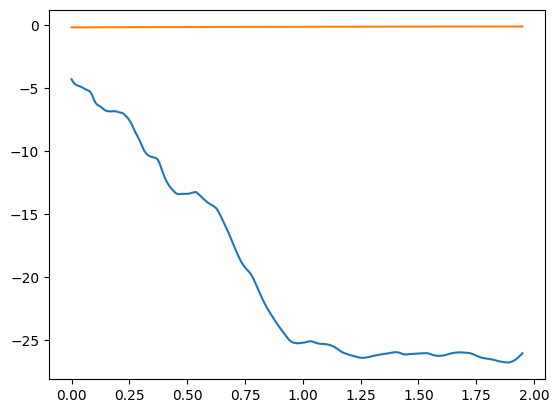

In [166]:
plt.plot(group_df['Time'], group_df['Fy'])
plt.plot(group_df['Time'], group_df['Fy_pred'])

In [124]:
preds[0].shape

(10000, 3)

In [103]:
plot_df.plot(x='Time', y='Fx')

KeyError: 'Time'

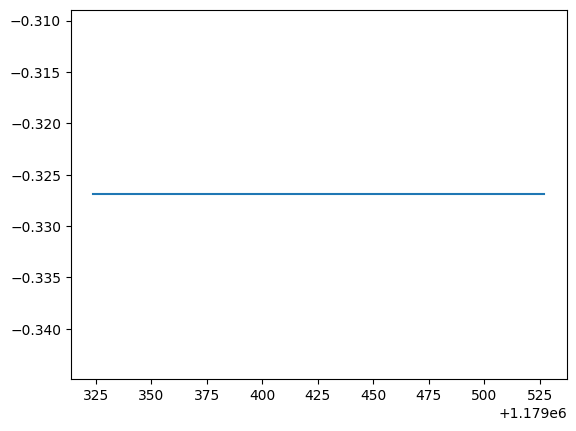

In [70]:
plt.plot(pred_plot[0]['Fx_pred'])